In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision
import torchaudio
#import torch_directml
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import numpy as np


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = datasets.ImageFolder(root='./traindata', transform= train_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    
    for images, _ in loader:
        # Accumulate the sum of pixel values for each channel
        batch_samples = images.size(0)  # Batch size (number of images in the batch)
        total_images_count += batch_samples
        mean += images.mean([0, 2, 3]) * batch_samples
        std += images.std([0, 2, 3]) * batch_samples
    
    # Final mean and standard deviation
    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Calculate mean and std for the dataset
mean, std = calculate_mean_std(loader)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5473, 0.4103, 0.3312])
Std: tensor([0.2913, 0.2981, 0.2977])


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5473, 0.4103, 0.3312], std=[0.2913, 0.2981, 0.2977])
])

In [6]:
augmentation_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(300, 300), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5473, 0.4103, 0.3312], std=[0.2913, 0.2981, 0.2977])

])

In [7]:
train_dataset = datasets.ImageFolder(root='./traindata', transform= train_transform)
augmented_train_dataset = datasets.ImageFolder(root='./traindata', transform=augmentation_transform)
train_dataset, augmented_train_dataset

(Dataset ImageFolder
     Number of datapoints: 4872
     Root location: ./traindata
     StandardTransform
 Transform: Compose(
                Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5473, 0.4103, 0.3312], std=[0.2913, 0.2981, 0.2977])
            ),
 Dataset ImageFolder
     Number of datapoints: 4872
     Root location: ./traindata
     StandardTransform
 Transform: Compose(
                Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                RandomResizedCrop(size=(300, 300), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
                ToTensor()
          

In [8]:
class_indices = {i: [] for i in range(len(augmented_train_dataset.classes))}
for idx, (_, label) in enumerate(augmented_train_dataset.imgs):
    class_indices[label].append(idx)

min_samples_per_class = 900 // len(class_indices)

# Create a new list of indices to keep (sampling evenly from each class)
subset_indices = []
for class_id, indices in class_indices.items():
    # Randomly select `min_samples_per_class` samples from each class
    subset_indices.extend(random.sample(indices, min_samples_per_class))

# Create a subset of the dataset with the desired number of samples
augmented_train_subset = Subset(augmented_train_dataset, subset_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


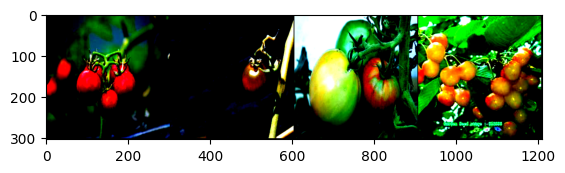

Class indices: tensor([2, 2, 2, 0])
Mapped class labels: ['tomato', 'tomato', 'tomato', 'cherry']


In [11]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the class names based on one of the datasets (ImageFolder uses the folder structure)
class_names = train_dataset.classes

num_classes = len(train_dataset.classes)

# Load the combined dataset
#combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

# Load the combined dataset using a DataLoader
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Get a batch of data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Display the images
imshow(torchvision.utils.make_grid(images))

# Print the corresponding class labels
print("Class indices:", labels)

# Map the class indices to their corresponding class names
mapped_labels = [class_names[label] for label in labels]
print("Mapped class labels:", mapped_labels)

In [9]:
combined_train_dataset = ConcatDataset([train_dataset, augmented_train_subset])
len(combined_train_dataset)

5772

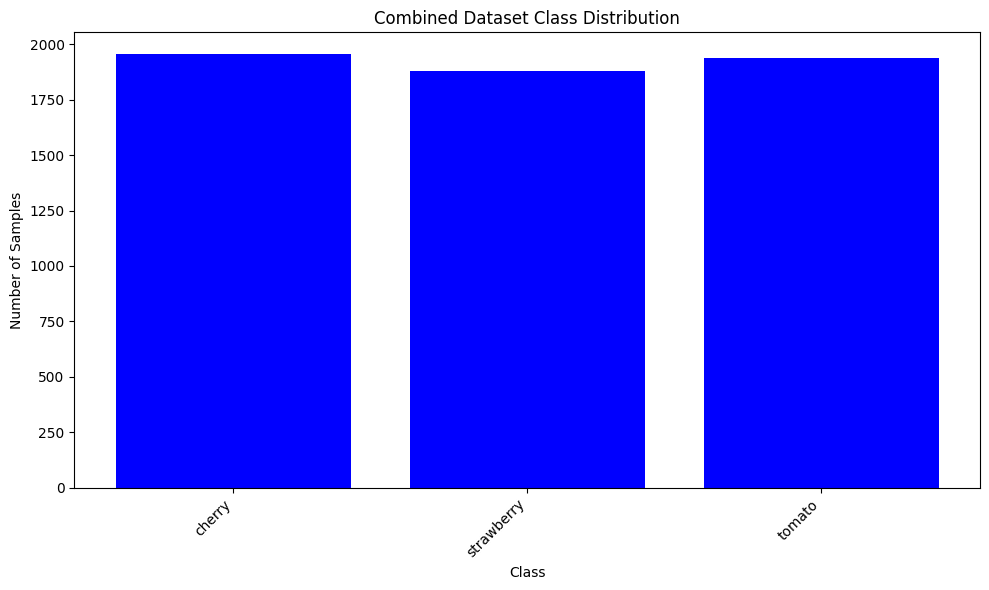

In [12]:
from collections import Counter

def plot_class_distribution(dataset, class_names, title="Class Distribution"):
    # Count the number of samples for each class in the dataset
    class_counts = Counter([label for _, label in dataset])

    # Create a list of counts in the order of class indices
    counts_per_class = [class_counts[i] for i in range(len(class_names))]

    # Plot class-wise distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts_per_class, color='blue')

    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the class distribution of the combined dataset
plot_class_distribution(combined_train_dataset, class_names, title="Combined Dataset Class Distribution")

In [13]:
# Check the tensor sizes
for img, _ in combined_train_dataset:
    print(f"Tensor size: {img.shape}")  # Tensor shape will be (C, H, W) where C=channels, H=height, W=width
    break

# Get unique tensor shapes for all images
sizes = [img.shape for img, _ in train_dataset]
unique_sizes = set(sizes)
print(f"Unique tensor shapes in the dataset: {unique_sizes}")

Tensor size: torch.Size([3, 300, 300])
Unique tensor shapes in the dataset: {torch.Size([3, 300, 300])}


In [14]:
num_classes = len(train_dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878819..2.246557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878819..2.246557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878819..2.1938655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878819..2.246557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878819..2.1543467].


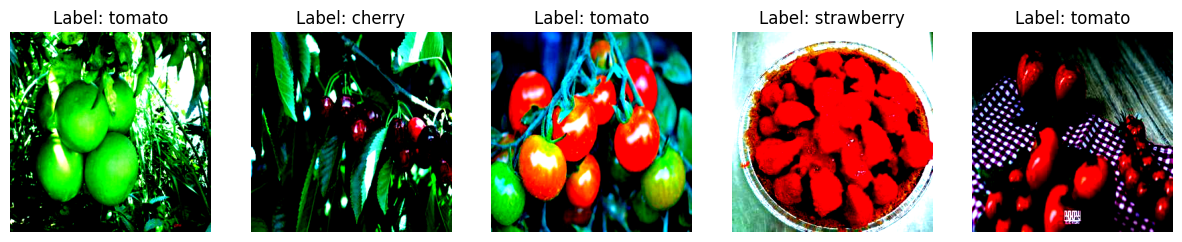

In [18]:
import random

def imshow(img_tensor):
    # Convert the tensor to a NumPy array
    img = img_tensor.numpy()  # Change shape from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure values are within the [0, 1] range
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to display random images from the dataset
def show_random_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    indices = np.random.choice(len(dataset), n, replace=False)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Rearrange dimensions to (H, W, C)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.show()

# Example usage
show_random_images(train_dataset, n=5)

In [15]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Assuming combined_train_dataset is defined elsewhere and holds the data
labels = [label for _, label in combined_train_dataset]
labels = torch.tensor(labels)

# Stratified split of data
train_indices, val_indices = train_test_split(
    range(len(combined_train_dataset)),  
    test_size=0.2,
    stratify=labels,
    random_state=42  # Optional: for reproducibility
)

# Define samplers based on the indices
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader for training and validation using stratified samplers
train_loader = DataLoader(combined_train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(combined_train_dataset, batch_size=32, sampler=val_sampler)

# Check the dataset sizes
print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")

# These should print correctly
print(f"Training DataLoader size: {len(train_loader.sampler)}")
print(f"Validation DataLoader size: {len(val_loader.sampler)}")

Training set size: 4617
Validation set size: 1155
Training DataLoader size: 4617
Validation DataLoader size: 1155


In [73]:
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 256)         # Second hidden layer
        self.fc3 = nn.Linear(256, 128)  # Hidden layer 2
        self.fc4 = nn.Linear(128, 3)    # Output layer (3 classes: tomato, cherry, strawberry)

    def forward(self, x):
        x = x.view(-1, 300 * 300 * 3)  # Flatten the input image
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layer 1
        x = torch.relu(self.fc2(x))  # ReLU activation for hidden layer 2
        x = torch.relu(self.fc3(x))  # ReLU activation for hidden layer 3
        x = self.fc4(x)          # Output layer (no activation, since we'll apply softmax with CrossEntropyLoss)
        return x

# Instantiate the model
model = MLPModel(input_size=300*300*3, num_classes=num_classes).to(device)
print(model)

MLPModel(
  (fc1): Linear(in_features=270000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
)


In [74]:
criterion = nn.CrossEntropyLoss()  # Cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [75]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize weights

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to the device
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/5: Train Loss: 1.2551, Train Accuracy: 0.4317, Validation Loss: 1.2789, Validation Accuracy: 0.4415
Epoch 2/5: Train Loss: 0.9741, Train Accuracy: 0.5806, Validation Loss: 1.3949, Validation Accuracy: 0.4280
Epoch 3/5: Train Loss: 0.8297, Train Accuracy: 0.6601, Validation Loss: 1.1852, Validation Accuracy: 0.4783
Epoch 4/5: Train Loss: 0.6347, Train Accuracy: 0.7486, Validation Loss: 1.2045, Validation Accuracy: 0.4879
Epoch 5/5: Train Loss: 0.5368, Train Accuracy: 0.8035, Validation Loss: 1.2953, Validation Accuracy: 0.5208


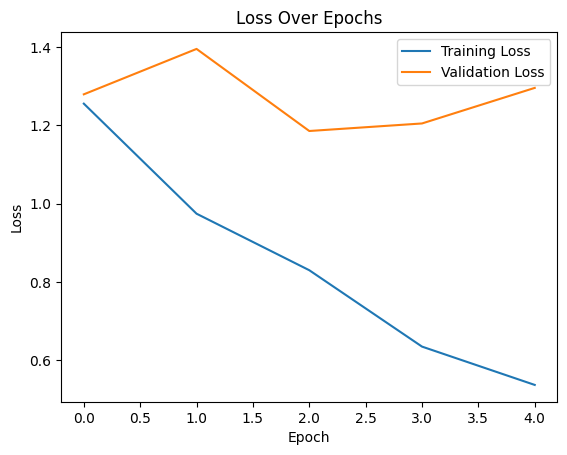

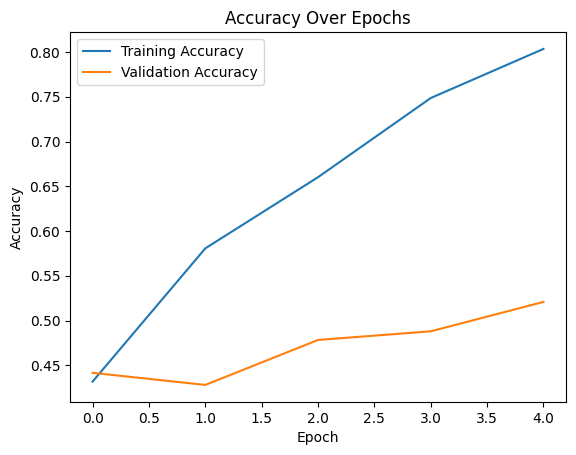

In [77]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Accuracy plot
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [237]:
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels (filters), 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Padding to maintain input dimensions
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # MaxPool to reduce dimensionality (downsampling)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 37 * 37, 512)  # After pooling, the size is 37x37 for 128 channels
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)  # Output layer (num of classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First convolution + ReLU + MaxPool
        x = self.pool(torch.relu(self.conv2(x)))  # Second convolution + ReLU + MaxPool
        x = self.pool(torch.relu(self.conv3(x)))  # Third convolution + ReLU + MaxPool
        
        x = x.view(-1, 128 * 37 * 37)  # Flatten the tensor for the fully connected layers
        x = torch.relu(self.fc1(x))     # First fully connected layer + ReLU
        x = torch.relu(self.fc2(x))     # Second fully connected layer + ReLU
        x = self.fc3(x)                 # Output layer (logits)
        return x



In [238]:
cnn_model = CNNModel().to(device)
print(cnn_model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=175232, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)


In [239]:
criterion = nn.CrossEntropyLoss()  # Cross entropy for classification
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0002)


In [240]:
def train_model_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize weights

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to the device
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the CNN model
num_epochs = 10
train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_model_cnn(cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/10: Train Loss: 0.9804, Train Accuracy: 0.5103, Validation Loss: 0.8763, Validation Accuracy: 0.6242
Epoch 2/10: Train Loss: 0.8044, Train Accuracy: 0.6481, Validation Loss: 0.9361, Validation Accuracy: 0.5700
Epoch 3/10: Train Loss: 0.6233, Train Accuracy: 0.7563, Validation Loss: 0.7622, Validation Accuracy: 0.6831
Epoch 4/10: Train Loss: 0.4167, Train Accuracy: 0.8472, Validation Loss: 0.7399, Validation Accuracy: 0.7034
Epoch 5/10: Train Loss: 0.2649, Train Accuracy: 0.9094, Validation Loss: 0.8142, Validation Accuracy: 0.6918
Epoch 6/10: Train Loss: 0.1638, Train Accuracy: 0.9475, Validation Loss: 0.9782, Validation Accuracy: 0.7111
Epoch 7/10: Train Loss: 0.1110, Train Accuracy: 0.9686, Validation Loss: 0.9253, Validation Accuracy: 0.7121
Epoch 8/10: Train Loss: 0.0827, Train Accuracy: 0.9749, Validation Loss: 1.0134, Validation Accuracy: 0.7150
Epoch 9/10: Train Loss: 0.0808, Train Accuracy: 0.9751, Validation Loss: 1.0320, Validation Accuracy: 0.7082
Epoch 10/10: Train 

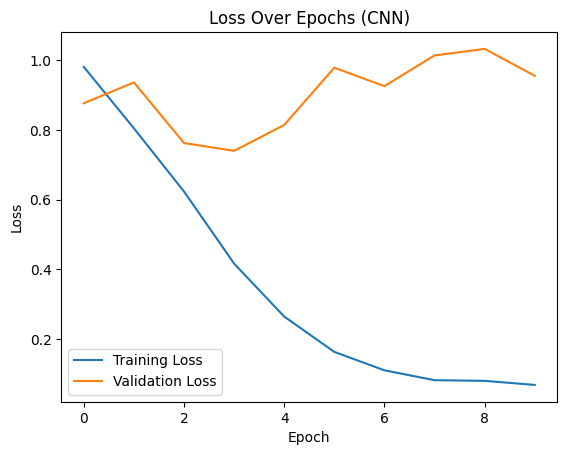

Text(0.5, 1.0, 'Accuracy Over Epochs (CNN)')

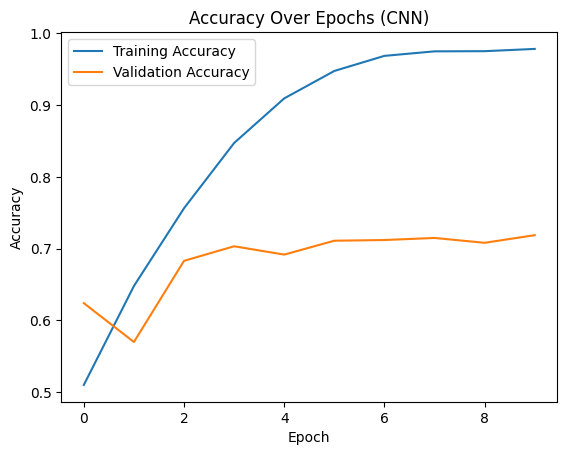

In [245]:
# Loss plot
plt.plot(train_losses_cnn, label="Training Loss")
plt.plot(val_losses_cnn, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs (CNN)')
plt.show()

# Accuracy plot
plt.plot(train_accuracies_cnn, label="Training Accuracy")
plt.plot(val_accuracies_cnn, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs (CNN)')


In [246]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold

# CNN Model Definition
class CNNModel_new(nn.Module):
    def __init__(self):
        super(CNNModel_new, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # MaxPool and Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers with Leaky ReLU activation
        self.fc1 = nn.Sequential(nn.Linear(128 * 37 * 37, 512), nn.LeakyReLU(0.1), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.LeakyReLU(0.1), nn.Dropout(0.5))
        self.fc3 = nn.Linear(256, 3)  # Adjust output layer for the number of classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 37 * 37)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)  # Output layer (logits)
        return x

# Focal Loss Definition (Optional for experimentation)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss


# Cross-validation function
def cross_validate_model(model, dataset, k=5, num_epochs=10, criterion=None, batch_size=32, lr=0.0001):
    kfold = KFold(n_splits=k, shuffle=True)
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"FOLD {fold+1}/{k}")
        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Reinitialize the model for each fold and move to device
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        model.to(device)  # Move model to device
        
        # Optimizer with weight decay and learning rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        # Train and evaluate the model
        train_model_cnn_new(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# Training function with scheduler support
def train_model_cnn_new(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Correct initialization

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize weights

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to device
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Step the scheduler if defined
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Instantiate the model and move it to the device
cnn_model_new = CNNModel_new().to(device)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

# Use the cross-validation function
# Assuming 'combined_train_dataset' is your dataset
cross_validate_model(cnn_model_new, combined_train_dataset, k=5, num_epochs=10, criterion=criterion)


FOLD 1/5
Epoch 1/10: Train Loss: 1.0363, Train Accuracy: 0.4602, Validation Loss: 0.9472, Validation Accuracy: 0.5768
Epoch 2/10: Train Loss: 0.8871, Train Accuracy: 0.6072, Validation Loss: 0.7878, Validation Accuracy: 0.6705
Epoch 3/10: Train Loss: 0.7471, Train Accuracy: 0.6899, Validation Loss: 0.7305, Validation Accuracy: 0.7043
Epoch 4/10: Train Loss: 0.6073, Train Accuracy: 0.7631, Validation Loss: 0.7382, Validation Accuracy: 0.6889
Epoch 5/10: Train Loss: 0.4801, Train Accuracy: 0.8206, Validation Loss: 0.6174, Validation Accuracy: 0.7411
Epoch 6/10: Train Loss: 0.3158, Train Accuracy: 0.9004, Validation Loss: 0.6222, Validation Accuracy: 0.7469
Epoch 7/10: Train Loss: 0.2838, Train Accuracy: 0.9106, Validation Loss: 0.6343, Validation Accuracy: 0.7459
Epoch 8/10: Train Loss: 0.2560, Train Accuracy: 0.9159, Validation Loss: 0.6588, Validation Accuracy: 0.7449
Epoch 9/10: Train Loss: 0.2411, Train Accuracy: 0.9255, Validation Loss: 0.6848, Validation Accuracy: 0.7382
Epoch 10/1

In [21]:
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
Train Loss: 0.7135, Train Accuracy: 0.7143
Val Loss: 0.8020, Val Accuracy: 0.7072
Epoch 2/10
Train Loss: 0.4670, Train Accuracy: 0.8298
Val Loss: 0.4339, Val Accuracy: 0.8367
Epoch 3/10
Train Loss: 0.3874, Train Accuracy: 0.8586
Val Loss: 0.4186, Val Accuracy: 0.8464
Epoch 4/10
Train Loss: 0.3613, Train Accuracy: 0.8671
Val Loss: 0.3551, Val Accuracy: 0.8676
Epoch 5/10
Train Loss: 0.2842, Train Accuracy: 0.8941
Val Loss: 0.5229, Val Accuracy: 0.8309
Epoch 6/10
Train Loss: 0.2723, Train Accuracy: 0.9033
Val Loss: 0.2803, Val Accuracy: 0.8841
Epoch 7/10
Train Loss: 0.2330, Train Accuracy: 0.9166
Val Loss: 0.4347, Val Accuracy: 0.8647
Epoch 8/10
Train Loss: 0.2315, Train Accuracy: 0.9164
Val Loss: 0.4739, Val Accuracy: 0.8010
Epoch 9/10
Train Loss: 0.2490, Train Accuracy: 0.9120
Val Loss: 0.2632, Val Accuracy: 0.9111
Epoch 10/10
Train Loss: 0.1917, Train Accuracy: 0.9309
Val Loss: 0.2626, Val Accuracy: 0.9034


Epoch 1/10
Train Loss: 0.7699, Train Accuracy: 0.6923
Val Loss: 0.5530, Val Accuracy: 0.7990
Epoch 2/10
Train Loss: 0.4929, Train Accuracy: 0.8102
Val Loss: 0.6193, Val Accuracy: 0.7797
Epoch 3/10
Train Loss: 0.4169, Train Accuracy: 0.8489
Val Loss: 0.4385, Val Accuracy: 0.8512
Epoch 4/10
Train Loss: 0.3506, Train Accuracy: 0.8762
Val Loss: 0.4082, Val Accuracy: 0.8589
Epoch 5/10
Train Loss: 0.2985, Train Accuracy: 0.8978
Val Loss: 0.3131, Val Accuracy: 0.8957
Epoch 6/10
Train Loss: 0.2898, Train Accuracy: 0.8951
Val Loss: 0.3554, Val Accuracy: 0.8821
Epoch 7/10
Train Loss: 0.2472, Train Accuracy: 0.9072
Val Loss: 0.4744, Val Accuracy: 0.8570
Epoch 8/10
Train Loss: 0.2327, Train Accuracy: 0.9183
Val Loss: 0.9259, Val Accuracy: 0.7459
Epoch 9/10
Train Loss: 0.2243, Train Accuracy: 0.9183
Val Loss: 0.3399, Val Accuracy: 0.8918
Epoch 10/10
Train Loss: 0.1723, Train Accuracy: 0.9364
Val Loss: 0.5555, Val Accuracy: 0.8338


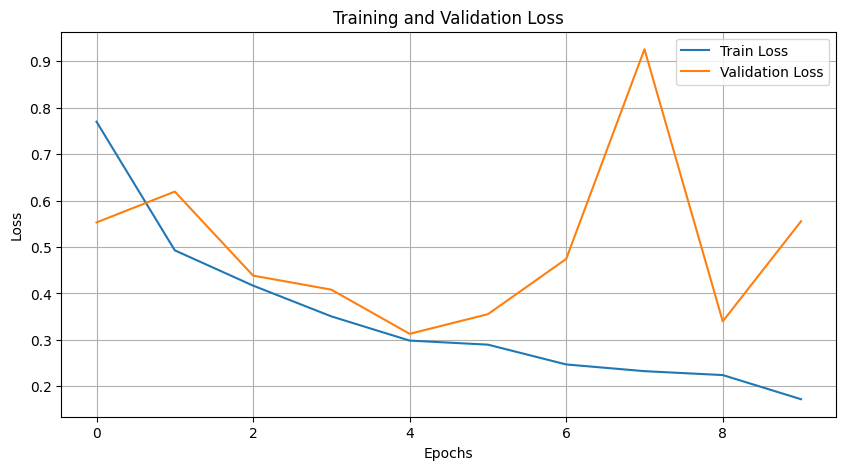

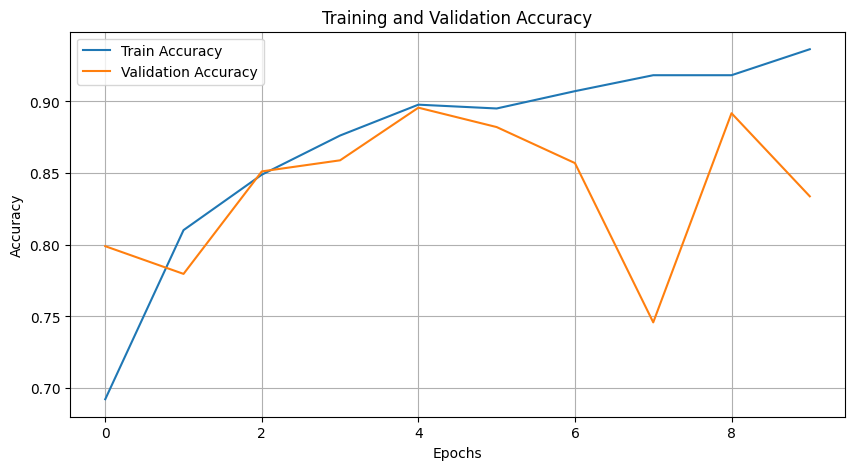

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the train function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10
Train Loss: 0.2425, Train Accuracy: 0.9139
Val Loss: 0.1188, Val Accuracy: 0.9623
Epoch 2/10
Train Loss: 0.0954, Train Accuracy: 0.9664
Val Loss: 0.1275, Val Accuracy: 0.9585
Epoch 3/10
Train Loss: 0.0669, Train Accuracy: 0.9773
Val Loss: 0.1067, Val Accuracy: 0.9662
Epoch 4/10
Train Loss: 0.0542, Train Accuracy: 0.9848
Val Loss: 0.1076, Val Accuracy: 0.9585
Epoch 5/10
Train Loss: 0.0702, Train Accuracy: 0.9775
Val Loss: 0.1062, Val Accuracy: 0.9652
Epoch 6/10
Train Loss: 0.0326, Train Accuracy: 0.9901
Val Loss: 0.1436, Val Accuracy: 0.9546
Epoch 7/10
Train Loss: 0.0250, Train Accuracy: 0.9906
Val Loss: 0.1224, Val Accuracy: 0.9662
Epoch 8/10
Train Loss: 0.0532, Train Accuracy: 0.9836
Val Loss: 0.1382, Val Accuracy: 0.9623
Epoch 9/10
Train Loss: 0.0258, Train Accuracy: 0.9927
Val Loss: 0.0923, Val Accuracy: 0.9700
Epoch 10/10
Train Loss: 0.0769, Train Accuracy: 0.9763
Val Loss: 0.1849, Val Accuracy: 0.9498


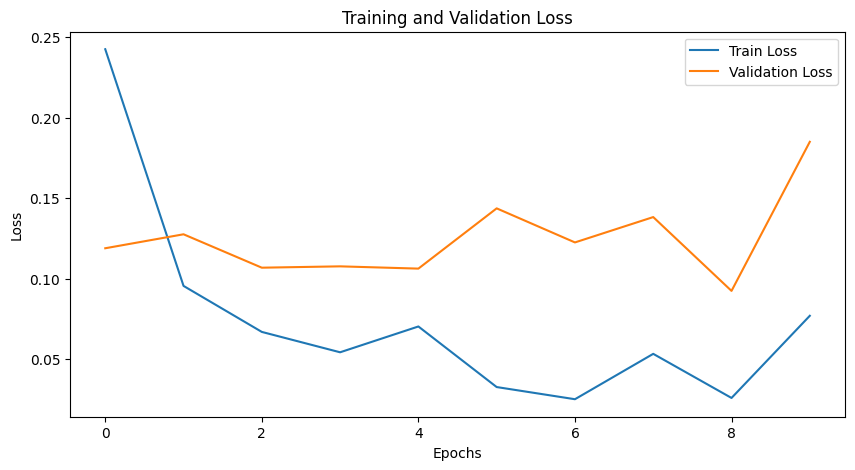

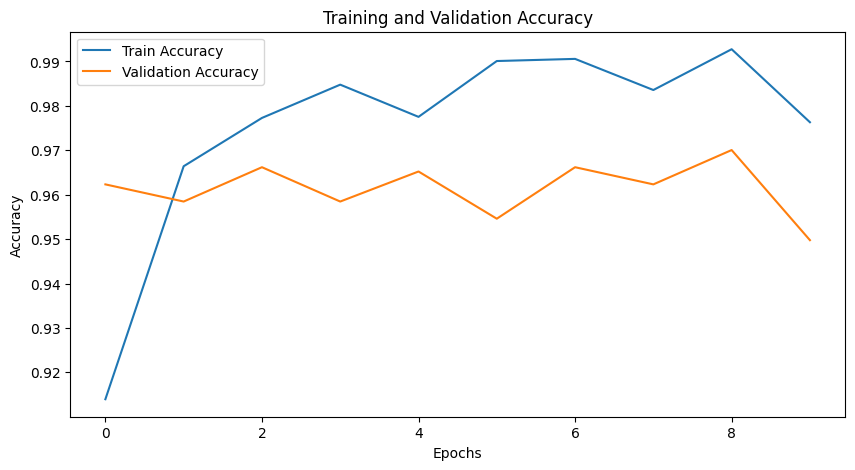

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the train function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


c:\Users\Rozorf-PC\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rozorf-PC\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 1.0647, Train Accuracy: 0.4361
Val Loss: 1.0357, Val Accuracy: 0.4899
Epoch 2/10
Train Loss: 1.0094, Train Accuracy: 0.5654
Val Loss: 0.9845, Val Accuracy: 0.6145
Epoch 3/10
Train Loss: 0.9586, Train Accuracy: 0.6749
Val Loss: 0.9394, Val Accuracy: 0.6995
Epoch 4/10
Train Loss: 0.9144, Train Accuracy: 0.7339
Val Loss: 0.8910, Val Accuracy: 0.7469
Epoch 5/10
Train Loss: 0.8741, Train Accuracy: 0.7730
Val Loss: 0.8560, Val Accuracy: 0.7932
Epoch 6/10
Train Loss: 0.8306, Train Accuracy: 0.8122
Val Loss: 0.8138, Val Accuracy: 0.8174
Epoch 7/10
Train Loss: 0.7936, Train Accuracy: 0.8272
Val Loss: 0.7712, Val Accuracy: 0.8357
Epoch 8/10
Train Loss: 0.7601, Train Accuracy: 0.8472
Val Loss: 0.7373, Val Accuracy: 0.8541
Epoch 9/10
Train Loss: 0.7253, Train Accuracy: 0.8593
Val Loss: 0.7017, Val Accuracy: 0.8599
Epoch 10/10
Train Loss: 0.6974, Train Accuracy: 0.8692
Val Loss: 0.6722, Val Accuracy: 0.8763


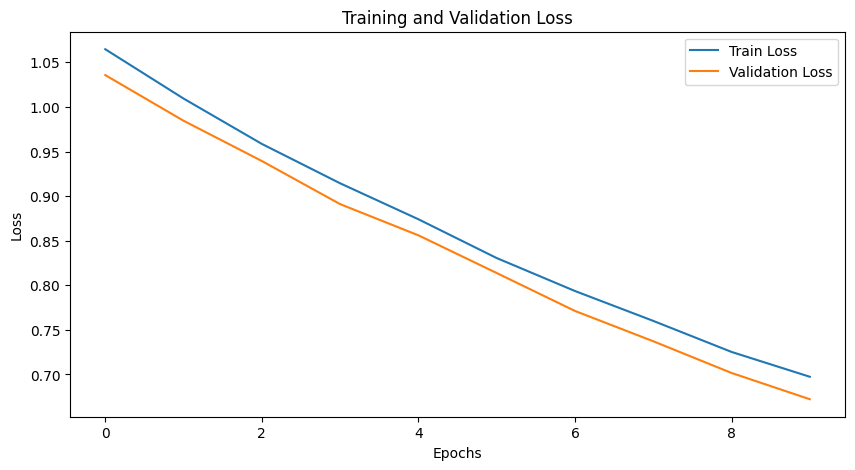

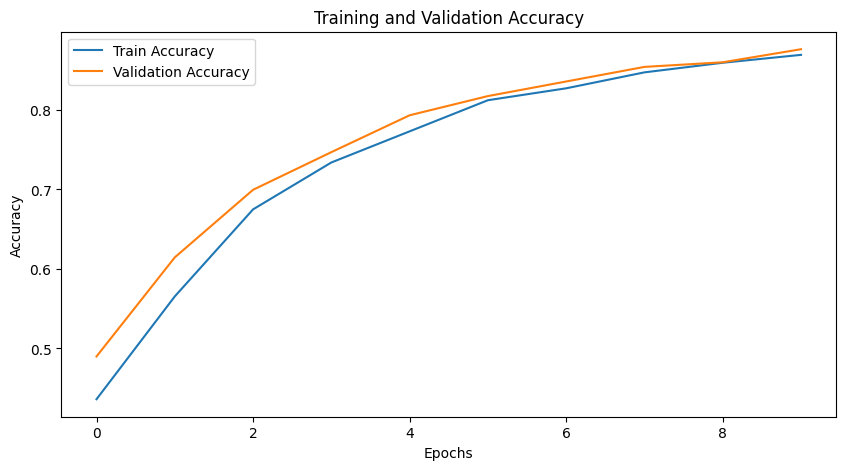

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the train function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


c:\Users\Rozorf-PC\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rozorf-PC\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 1.1340, Train Accuracy: 0.4160
Val Loss: 1.1170, Val Accuracy: 0.4077
Epoch 2/10
Train Loss: 0.9486, Train Accuracy: 0.5555
Val Loss: 0.9859, Val Accuracy: 0.6415
Epoch 3/10
Train Loss: 0.7625, Train Accuracy: 0.6855
Val Loss: 1.0801, Val Accuracy: 0.6483
Epoch 4/10
Train Loss: 0.6910, Train Accuracy: 0.7283
Val Loss: 0.7160, Val Accuracy: 0.7159
Epoch 5/10
Train Loss: 0.6350, Train Accuracy: 0.7404
Val Loss: 0.6968, Val Accuracy: 0.7159
Epoch 6/10
Train Loss: 0.5932, Train Accuracy: 0.7692
Val Loss: 0.6349, Val Accuracy: 0.7758
Epoch 7/10
Train Loss: 0.5348, Train Accuracy: 0.7902
Val Loss: 0.5482, Val Accuracy: 0.8019
Epoch 8/10
Train Loss: 0.4961, Train Accuracy: 0.8093
Val Loss: 0.8522, Val Accuracy: 0.7111
Epoch 9/10
Train Loss: 0.4900, Train Accuracy: 0.8153
Val Loss: 0.6714, Val Accuracy: 0.7208
Epoch 10/10
Train Loss: 0.4562, Train Accuracy: 0.8277
Val Loss: 0.4678, Val Accuracy: 0.8242


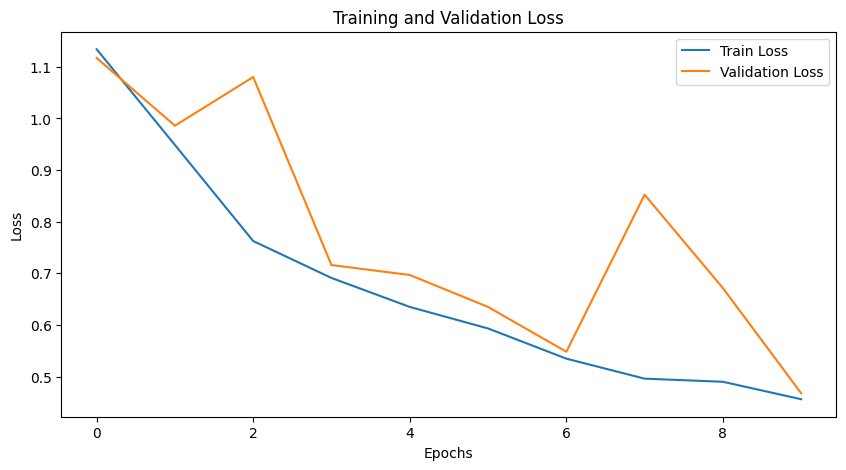

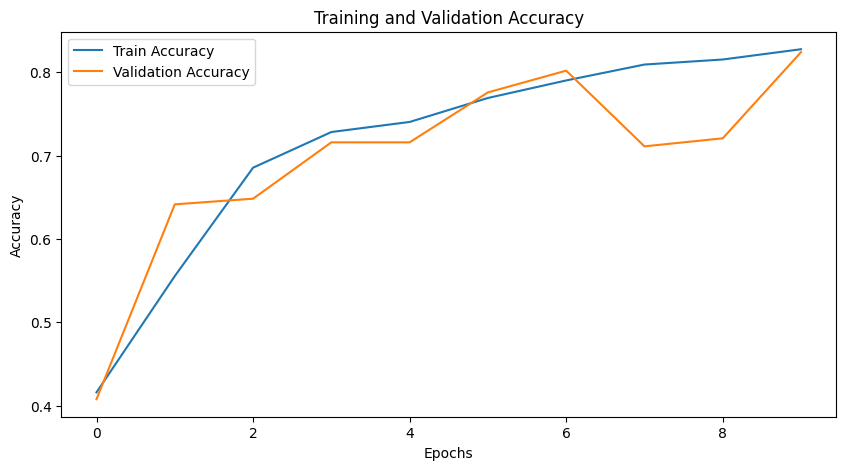

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0.9)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the train function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10
Train Loss: 0.9061, Train Accuracy: 0.6795
Val Loss: 0.7044, Val Accuracy: 0.8396
Epoch 2/10
Train Loss: 0.5868, Train Accuracy: 0.8772
Val Loss: 0.4752, Val Accuracy: 0.9005
Epoch 3/10
Train Loss: 0.4106, Train Accuracy: 0.9115
Val Loss: 0.3589, Val Accuracy: 0.9198
Epoch 4/10
Train Loss: 0.3206, Train Accuracy: 0.9263
Val Loss: 0.2794, Val Accuracy: 0.9256
Epoch 5/10
Train Loss: 0.2586, Train Accuracy: 0.9350
Val Loss: 0.2398, Val Accuracy: 0.9333
Epoch 6/10
Train Loss: 0.2235, Train Accuracy: 0.9413
Val Loss: 0.2054, Val Accuracy: 0.9440
Epoch 7/10
Train Loss: 0.1970, Train Accuracy: 0.9451
Val Loss: 0.1865, Val Accuracy: 0.9488
Epoch 8/10
Train Loss: 0.1743, Train Accuracy: 0.9509
Val Loss: 0.1720, Val Accuracy: 0.9507
Epoch 9/10
Train Loss: 0.1588, Train Accuracy: 0.9514
Val Loss: 0.1534, Val Accuracy: 0.9594
Epoch 10/10
Train Loss: 0.1464, Train Accuracy: 0.9579
Val Loss: 0.1393, Val Accuracy: 0.9604


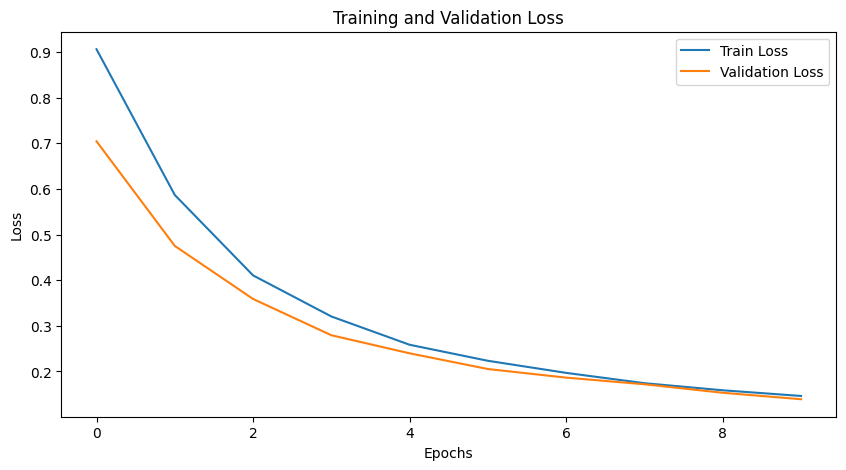

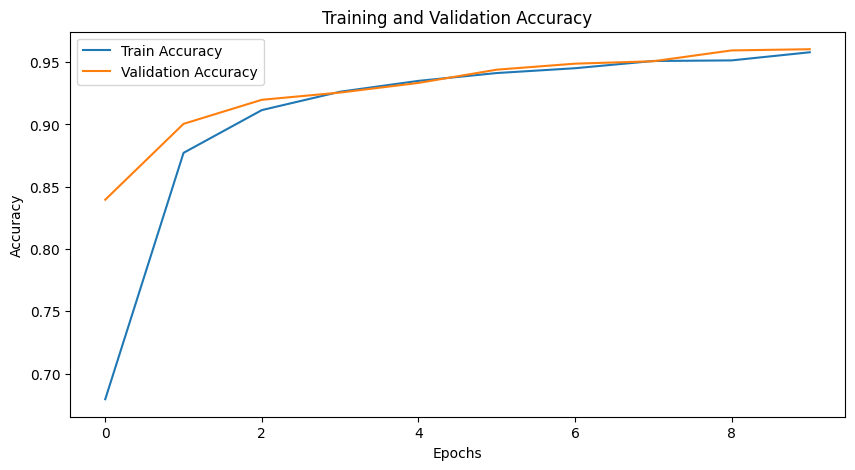

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.sampler)
        epoch_acc = correct_preds.double() / len(train_loader.sampler)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels)

        val_loss = val_loss / len(val_loader.sampler)
        val_acc = correct_val_preds.double() / len(val_loader.sampler)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the train function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Fold 1/5
Epoch 1/5
Train Loss: 0.8985, Train Accuracy: 0.7005
Val Loss: 0.6997, Val Accuracy: 0.8589
Epoch 2/5
Train Loss: 0.5845, Train Accuracy: 0.8857
Val Loss: 0.4792, Val Accuracy: 0.8918
Epoch 3/5
Train Loss: 0.4130, Train Accuracy: 0.9069
Val Loss: 0.3633, Val Accuracy: 0.9101
Epoch 4/5
Train Loss: 0.3164, Train Accuracy: 0.9253
Val Loss: 0.2913, Val Accuracy: 0.9256
Epoch 5/5
Train Loss: 0.2679, Train Accuracy: 0.9248
Val Loss: 0.2447, Val Accuracy: 0.9430


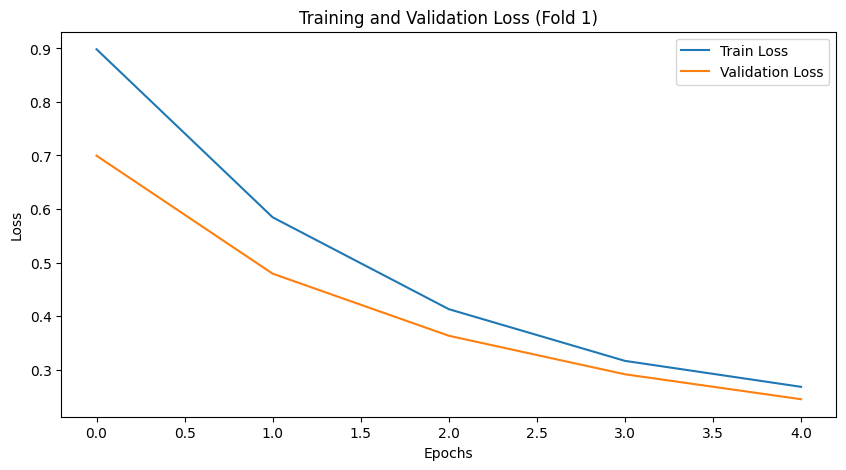

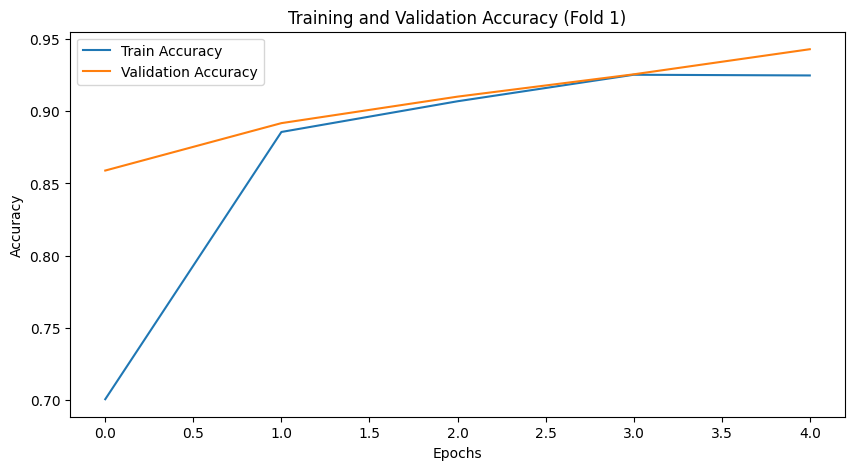


Fold 2/5
Epoch 1/5
Train Loss: 0.8746, Train Accuracy: 0.7227
Val Loss: 0.6723, Val Accuracy: 0.8725
Epoch 2/5
Train Loss: 0.5617, Train Accuracy: 0.8854
Val Loss: 0.4423, Val Accuracy: 0.9082
Epoch 3/5
Train Loss: 0.4020, Train Accuracy: 0.9118
Val Loss: 0.3253, Val Accuracy: 0.9256
Epoch 4/5
Train Loss: 0.3120, Train Accuracy: 0.9214
Val Loss: 0.2568, Val Accuracy: 0.9353
Epoch 5/5
Train Loss: 0.2597, Train Accuracy: 0.9318
Val Loss: 0.2155, Val Accuracy: 0.9449


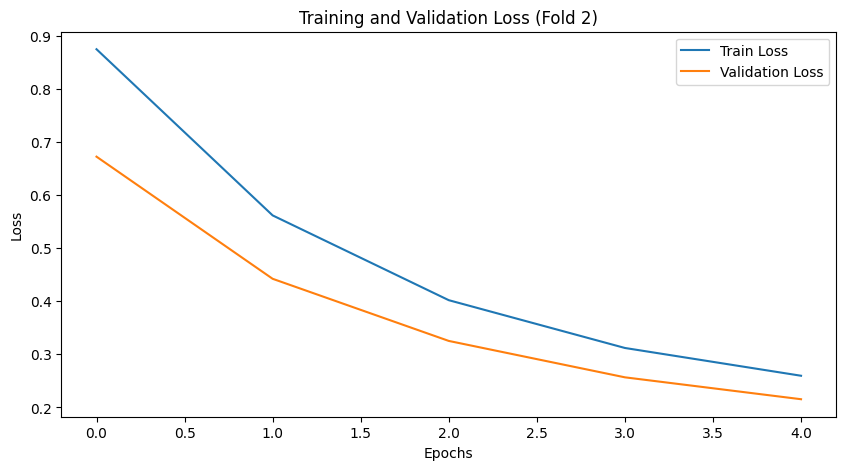

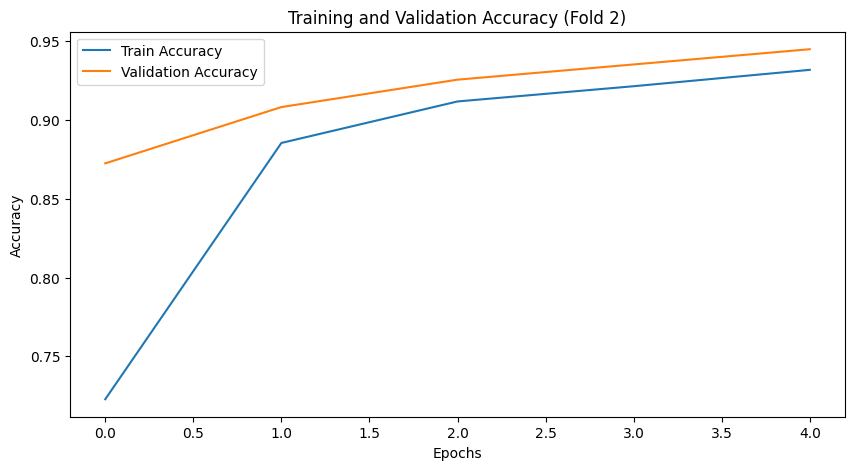


Fold 3/5
Epoch 1/5
Train Loss: 0.8891, Train Accuracy: 0.6890
Val Loss: 0.6781, Val Accuracy: 0.8598
Epoch 2/5
Train Loss: 0.5811, Train Accuracy: 0.8753
Val Loss: 0.4520, Val Accuracy: 0.9004
Epoch 3/5
Train Loss: 0.4159, Train Accuracy: 0.9026
Val Loss: 0.3282, Val Accuracy: 0.9275
Epoch 4/5
Train Loss: 0.3207, Train Accuracy: 0.9171
Val Loss: 0.2738, Val Accuracy: 0.9265
Epoch 5/5
Train Loss: 0.2661, Train Accuracy: 0.9304
Val Loss: 0.2194, Val Accuracy: 0.9487


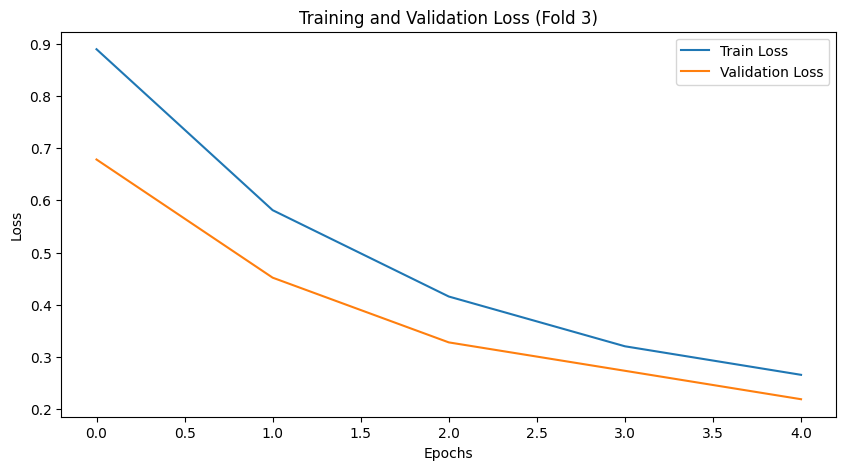

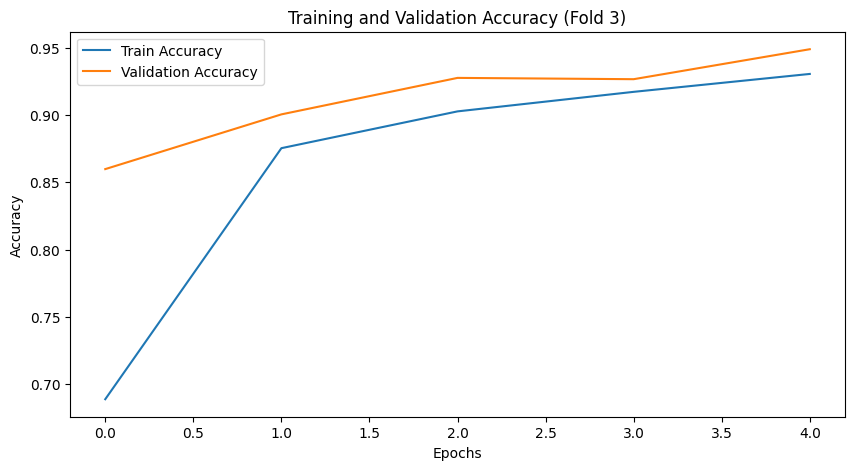


Fold 4/5
Epoch 1/5
Train Loss: 0.8989, Train Accuracy: 0.6837
Val Loss: 0.6854, Val Accuracy: 0.8743
Epoch 2/5
Train Loss: 0.5849, Train Accuracy: 0.8758
Val Loss: 0.4588, Val Accuracy: 0.9091
Epoch 3/5
Train Loss: 0.4153, Train Accuracy: 0.9084
Val Loss: 0.3406, Val Accuracy: 0.9226
Epoch 4/5
Train Loss: 0.3259, Train Accuracy: 0.9178
Val Loss: 0.2749, Val Accuracy: 0.9323
Epoch 5/5
Train Loss: 0.2647, Train Accuracy: 0.9302
Val Loss: 0.2308, Val Accuracy: 0.9313


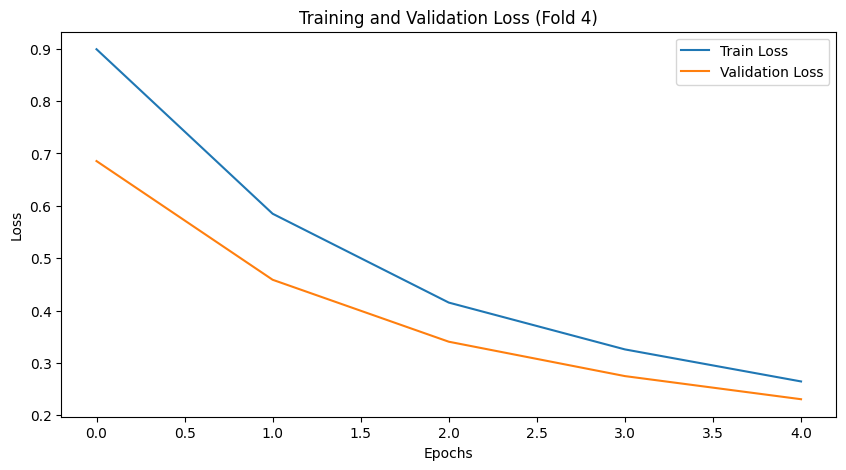

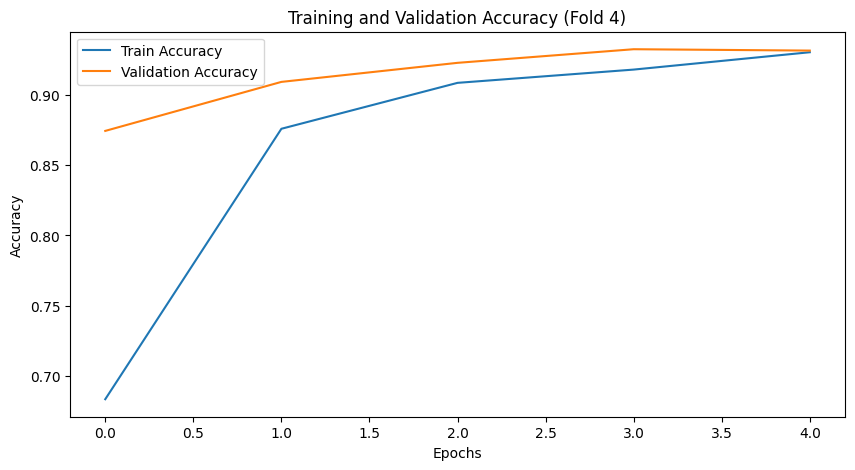


Fold 5/5
Epoch 1/5
Train Loss: 0.9012, Train Accuracy: 0.6839
Val Loss: 0.6845, Val Accuracy: 0.8665
Epoch 2/5
Train Loss: 0.5904, Train Accuracy: 0.8748
Val Loss: 0.4518, Val Accuracy: 0.9091
Epoch 3/5
Train Loss: 0.4168, Train Accuracy: 0.9082
Val Loss: 0.3223, Val Accuracy: 0.9265
Epoch 4/5
Train Loss: 0.3184, Train Accuracy: 0.9207
Val Loss: 0.2577, Val Accuracy: 0.9362
Epoch 5/5
Train Loss: 0.2646, Train Accuracy: 0.9314
Val Loss: 0.2223, Val Accuracy: 0.9371


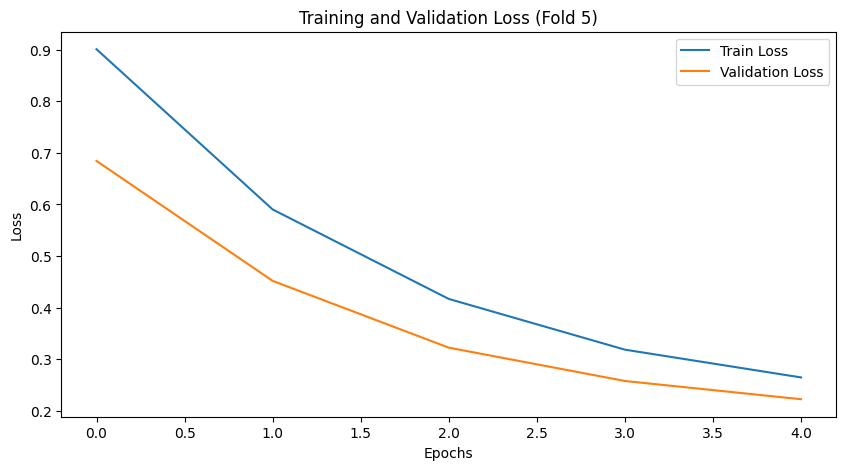

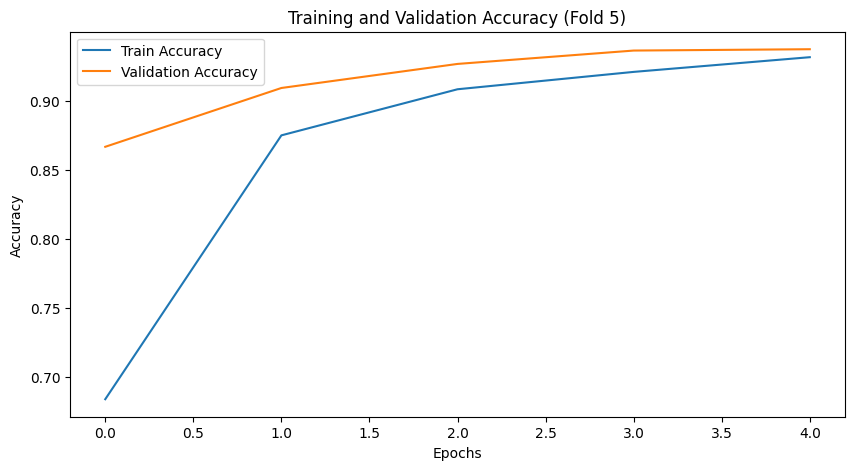

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

# Initialize the model
model = None
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your 3 classes (cherry, tomato, strawberry)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 output classes

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# K-Fold Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to train the model using K-Fold Cross-validation
def train_kfold(model, dataset, criterion, optimizer, num_epochs=10):
    fold = 0
    for train_indices, val_indices in kf.split(dataset):
        fold += 1
        print(f'\nFold {fold}/5')
        
        # Creating data samplers and loaders for this fold
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
        
        # Reset model to pre-trained weights before each fold
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(num_ftrs, 3)
        model = model.to(device)
        
        # Optimizer reset for each fold
        optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct_preds = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Accumulate training statistics
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels)

            epoch_loss = running_loss / len(train_loader.sampler)
            epoch_acc = correct_preds.double() / len(train_loader.sampler)

            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct_val_preds = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    correct_val_preds += torch.sum(preds == labels)

            val_loss = val_loss / len(val_loader.sampler)
            val_acc = correct_val_preds.double() / len(val_loader.sampler)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())

            # Print epoch stats
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Plot training and validation loss curves for each fold
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss (Fold {fold})')
        plt.legend()
        plt.show()

        # Plot training and validation accuracy curves for each fold
        plt.figure(figsize=(10, 5))
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Training and Validation Accuracy (Fold {fold})')
        plt.legend()
        plt.show()

# Assuming your dataset is `combined_train_dataset`
train_kfold(model, combined_train_dataset, criterion, optimizer, num_epochs=5)


In [83]:
torch.save(model.state_dict(), 'model_sgd.pth')

# Load the model for testing
model.load_state_dict(torch.load('model_sgd.pth'))
model.eval()

C:\Users\Rozorf-PC\AppData\Local\Temp\ipykernel_9668\802470574.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_sgd.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def test_model_cnn(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute predictions
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate test loss
            test_loss += loss.item() * images.size(0)

            # Get predicted classes
            _, predicted = torch.max(outputs, 1)
            
            # Update the total number of labels and correct predictions
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / total_test
    test_accuracy = correct_test / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return avg_test_loss, test_accuracy

In [47]:
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Initialize counters for each class
    class_correct = [0 for _ in range(len(class_names))]
    class_total = [0 for _ in range(len(class_names))]

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute predictions
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate test loss
            test_loss += loss.item() * images.size(0)

            # Get predicted classes
            _, predicted = torch.max(outputs, 1)
            
            # Update total number of labels and correct predictions for overall accuracy
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Update correct and total counts for each class
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if pred == label:
                    class_correct[label] += 1
                class_total[label] += 1

    # Calculate average test loss and overall accuracy
    avg_test_loss = test_loss / total_test
    test_accuracy = correct_test / total_test

    # Print overall test loss and accuracy
    print(f"Test Loss: {avg_test_loss:.4f}, Overall Test Accuracy: {test_accuracy:.4f}")

    # Print accuracy for each class
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:  # Avoid division by zero
            class_accuracy = class_correct[i] / class_total[i]
            print(f'Accuracy of {class_name}: {class_accuracy:.4f} ({class_correct[i]}/{class_total[i]})')

    return avg_test_loss, test_accuracy


In [51]:
test_dataset = datasets.ImageFolder(root='./testdata', transform= train_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [78]:
class_names = ['cherry', 'tomato', 'strawberry']
avg_test_loss, test_accuracy = test_model(model, test_loader, criterion, class_names)

Test Loss: 1.0348, Overall Test Accuracy: 0.5560
Accuracy of cherry: 0.5735 (281/490)
Accuracy of tomato: 0.4714 (239/507)
Accuracy of strawberry: 0.6255 (309/494)


In [82]:
class_names = ['cherry', 'tomato', 'strawberry']
avg_test_loss, test_accuracy = test_model(model, test_loader, criterion, class_names)

c:\Users\Rozorf-PC\miniconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.0775, Overall Test Accuracy: 0.9765
Accuracy of cherry: 0.9510 (466/490)
Accuracy of tomato: 0.9961 (505/507)
Accuracy of strawberry: 0.9818 (485/494)


In [56]:
test_loss, test_accuracy = test_model_cnn(model, test_loader, criterion)

# Print the results
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0699, Test Accuracy: 0.9819
Final Test Loss: 0.0699
Final Test Accuracy: 0.9819
